In [6]:
import pandas as pd
import numpy as np
import itertools

import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

In [7]:
input_size = (28, 28)

def preprocess_dataset(image):
    image = tf.image.resize(image, (input_size[0], input_size[1]))
    return image.numpy()

In [3]:
# walk the directory containing alpaca/not alpaca and read them in. 
# might be different shapes
# all have 3 channels
alpaca_images = []
for dirname, _, filenames in os.walk('dataset/alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            alpaca_images.append(imnp)

not_alpaca_images = []
for dirname, _, filenames in os.walk('dataset/not alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            not_alpaca_images.append(imnp)

Metal device set to: Apple M1


2023-03-22 15:20:54.949286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-22 15:20:54.949428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


This is 1 channel, so we omit it (683, 1024) 4b9ef3ce2685ee32.jpg
This is 1 channel, so we omit it (914, 1024) 5a71db307230880e.jpg


## Preprocessing data

In [4]:
# scale image from [0, 255] to [0, 1]
alpaca_images = np.asarray(alpaca_images) / 255.
not_alpaca_images = np.asarray(not_alpaca_images) / 255.

# loading data
X = np.concatenate((alpaca_images, not_alpaca_images), axis=0) # X.shape=(325, 300, 300, 3)

# 0 -> alpaca_images, 1-> not_alpaca_images
y = np.concatenate((np.zeros(alpaca_images.shape[0], dtype=int),  # y.shape=(325,)
                    np.ones(not_alpaca_images.shape[0], dtype=int)), 
                   axis=0)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(292, 28, 28, 3) (292,)
(33, 28, 28, 3) (33,)


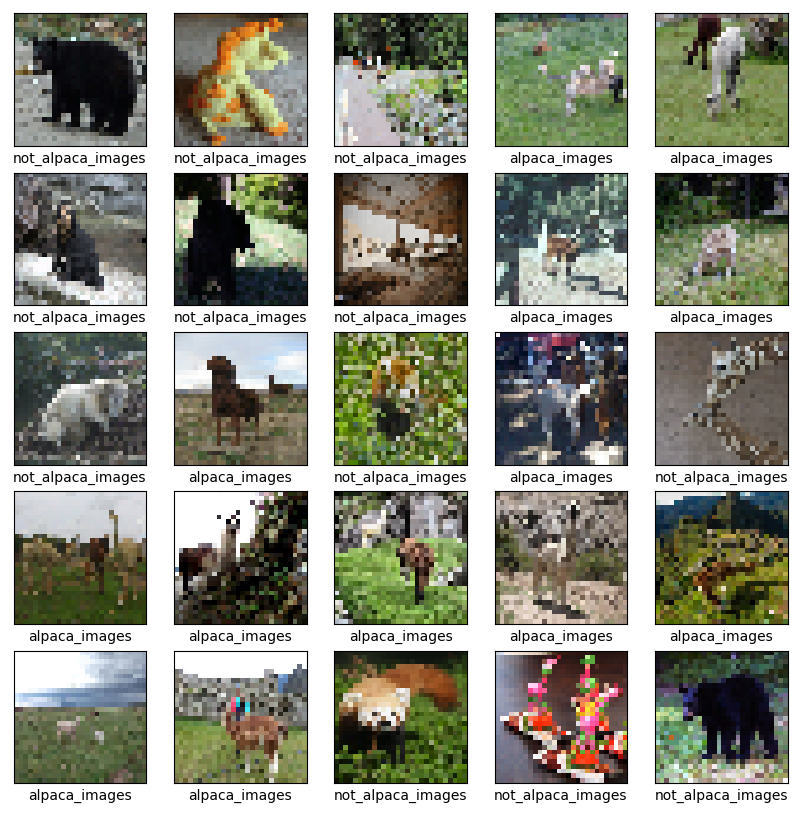

In [79]:
class_names = ['alpaca_images', 'not_alpaca_images']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[int(y_train[i])])
plt.show()

## 2D CNN Model 

In [67]:
cnn2d = keras.Sequential((
    # input layer
    keras.Input(shape=(input_size[0], input_size[1], 3)),
    # convolutional layer1 + ActivationLayer1
    layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer1
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer2 + ActivationLayer2
    layers.Conv2D(filters=12, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer2
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer3 + ActivationLayer33
    layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # Dense layer1
    layers.Flatten(name='flatten'),
    layers.Dense(12),
    
    # output layer
    layers.Dense(1, activation='softmax'),
))

In [68]:
cnn2d.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 average_pooling2d_16 (Avera  (None, 149, 149, 16)     0         
 gePooling2D)                                                    
                                                                 
 conv2d_25 (Conv2D)          (None, 147, 147, 12)      1740      
                                                                 
 average_pooling2d_17 (Avera  (None, 73, 73, 12)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_26 (Conv2D)          (None, 71, 71, 8)         872       
                                                                 
 flatten (Flatten)           (None, 40328)            

## Train 2D CNN Model

In [74]:
batch_size = 128
epochs = 3

cnn2d.compile(loss="mean_squared_logarithmic_error", 
              optimizer="adam",
              metrics=[
                       #"accuracy", 
                       tf.keras.metrics.Accuracy(),
                       tf.keras.metrics.Precision(thresholds=0.5),
                       tf.keras.metrics.Recall(thresholds=0.5)
                      ])


cnn2d.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

cnn2d.save("keras_2dcnn.saved_model")

Epoch 1/3


2023-03-09 15:13:47.107799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 396ms/step - loss: 0.2164 - accuracy: 0.5496 - precision_9: 0.5496 - recall_3: 1.0000 - val_loss: 0.1762 - val_accuracy: 0.6333 - val_precision_9: 0.6333 - val_recall_3: 1.0000
Epoch 2/3


2023-03-09 15:13:48.317159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 232ms/step - loss: 0.2164 - accuracy: 0.5496 - precision_9: 0.5496 - recall_3: 1.0000 - val_loss: 0.1762 - val_accuracy: 0.6333 - val_precision_9: 0.6333 - val_recall_3: 1.0000
Epoch 3/3
3/3 [==============================] - 1s 231ms/step - loss: 0.2164 - accuracy: 0.5496 - precision_9: 0.5496 - recall_3: 1.0000 - val_loss: 0.1762 - val_accuracy: 0.6333 - val_precision_9: 0.6333 - val_recall_3: 1.0000


INFO:tensorflow:Assets written to: keras_2dcnn.saved_model/assets


INFO:tensorflow:Assets written to: keras_2dcnn.saved_model/assets


## Evaluate the 2D CNN

In [76]:
cnn2d.evaluate(
    x=X_test,
    y=y_test)

2/2 [==============================] - 1s 407ms/step - loss: 0.1893 - accuracy: 0.6061 - precision_9: 0.6061 - recall_3: 1.0000


[0.1892692744731903, 0.6060606241226196, 0.6060606241226196, 1.0]

# Proposed layer

In [71]:
a = tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 5, 6, 7, 8], shape=[3, 2, 2])
print(a)

b = tf.constant([1, 2, 3, 4], shape=[1, 2, 2])
print(b)

x = tf.matmul(a, b)
print(x)

tf.Tensor(
[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]

 [[5 6]
  [7 8]]], shape=(3, 2, 2), dtype=int32)
tf.Tensor(
[[[1 2]
  [3 4]]], shape=(1, 2, 2), dtype=int32)
tf.Tensor(
[[[ 7 10]
  [15 22]]

 [[23 34]
  [31 46]]

 [[23 34]
  [31 46]]], shape=(3, 2, 2), dtype=int32)


In [113]:
test = initializer(shape=(1,3,3, 3))
weights_matrix = initializer(shape=(3,3, 3, 16))
# tf.experimental.numpy.dot(test, weights_matrix).shape
tf.linalg.matmul(test, weights_matrix).shape
# layers.Flatten(test)

TensorShape([3, 3, 3, 16])

TensorShape([3, 2, 2])

In [16]:
# for values in itertools.product(range(1),range(2), range(3), range(3)):
#     print(values)
np.dot()

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 2, 2)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 1, 2, 2)


In [22]:
class ProposedLayer(layers.Conv2D):
    def convolution_op(self, inputs, kernel):
        # print(inputs)
        # print(tf.shape(inputs), tf.shape(kernel))
        # print(self.__class__.__name__)
        b = inputs.shape[0]
        x = inputs.shape[1]
        y = inputs.shape[2]

        k_b = kernel.shape[2]
        k_x = kernel.shape[0]
        k_y = kernel.shape[1]
        k_f = kernel.shape[3]
        # print(k_f)
        
        o_x = o_y = int((x+0+0-k_x)//1 + 1)
        
        initializer = tf.keras.initializers.GlorotNormal()
        # weights_matrix = np.random.rand(*(k_b, x, y, k_f))
        weights_matrix = initializer(shape=(k_b, x, y, k_f))
        # print(weights_matrix.shape)
        
        outputs = []
        
        for values in itertools.product(range(b), range(k_f), range(x-k_x+1), range(y-k_y+1)): ## loop for each image and filters
            bs = values[0]
            fs = values[1]
            h = values[2]
            w = values[3]
            # for fs in range(k_f): ## loop for filter size 
            # for h in range(x-k_x+1): ## loop for height
            #     for w in range(y-k_y+1): ## loop for width
            value = tf.experimental.numpy.vdot(
                inputs[bs:bs+1, h:h+k_x, w:w+k_y, :], 
                weights_matrix[:, h:h+k_x, w:w+k_y, fs:fs+1]
            ) ##output single float value
            outputs.append(value)
        return tf.reshape(outputs, [b, o_x, o_y, k_f])


In [23]:
initializer = tf.keras.initializers.GlorotNormal()
test_input = initializer(shape=(2,10, 10, 3))

In [24]:
# input = keras.Input(shape=(5, 5, 3))
ProposedLayer(12, kernel_size=(3, 3), strides=(1, 1), activation='relu')(test_input).shape
# layers.AveragePooling2D(pool_size=(2, 2))(x)

TensorShape([2, 8, 8, 12])

In [80]:
class ProposedModel(tf.Module):
    def __init__(self):
        super().__init__()
        
        self.pl_16 = ProposedLayer(16, kernel_size=(3, 3), strides=(1, 1), activation='relu')
        self.pl_12 = ProposedLayer(12, kernel_size=(3, 3), strides=(1, 1), activation='relu')
        self.pl_8 = ProposedLayer(8, kernel_size=(3, 3), strides=(1, 1), activation='relu')
        
        self.pool_2_2 = layers.AveragePooling2D(pool_size=(2, 2))
        
        self.flatten = layers.Flatten(name='flatten')
        self.dense_12 = layers.Dense(12)
        self.output = layers.Dense(1, activation='softmax')
        
    def __call__(self, x):
        x = self.pl_16(x)
        x = self.pool_2_2(x)
        print(x.shape)
        # x = self.pl2(x)
        return x

In [82]:
pm = ProposedModel()

pm(X_train).shape

KeyboardInterrupt: 